# 0. Import data


In [386]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [387]:
os.getcwd()

'C:\\Users\\smart'

In [388]:
data_sample_raw = pd.read_csv(r'~\Desktop\GitHub\EQworks\Data\DataSample.csv')

In [389]:
print('number of rows:', len(data_sample_raw.index))
data_sample_raw.tail()

number of rows: 22025


,_ID,TimeSt,Country,Province,City,Latitude,Longitude
22020,5614801,2017-06-21 12:23,CA,ON,Saint Catharines,43.16440,-79.24560
22021,5614888,2017-06-21 8:23,CA,AB,Calgary,51.02093,-114.10621
22022,5614909,2017-06-21 0:23,CA,ON,Whitby,43.88730,-78.94220
22023,5614912,2017-06-21 11:23,CA,ON,Oakville,43.49340,-79.71260
22024,5615006,2017-06-21 17:23,CA,ON,Oakville,43.43090,-79.77670


In [390]:
poi_list = pd.read_csv(r'~\Desktop\GitHub\EQworks\Data\POIList.csv')
poi_list

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


In [391]:
# POI1 and POI2 have identical longtitude and latitude; therefore the POI df will be shrunk to 3 IDs
poi_list_v1 = poi_list[1:]
poi_list_v1

,POIID,Latitude,Longitude
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


In [392]:
poi2_coord = (poi_list_v1.loc[1,'Latitude'],poi_list_v1.loc[1,'Longitude'])
poi3_coord = (poi_list_v1.loc[2,'Latitude'],poi_list_v1.loc[2,'Longitude'])
poi4_coord = (poi_list_v1.loc[3,'Latitude'],poi_list_v1.loc[3,'Longitude'])
pois_coord_list = [poi2_coord, poi3_coord, poi4_coord]
pois = ['poi2','poi3','poi4']

In [393]:
pois_coord_list[2][1]

-63.232729000000006

# 1. Cleanup
### Find the sample dataset of request logs in data/DataSample.csv. We consider records that have identical geoinfo and timest as suspicious. Please clean up the sample dataset by filtering out those questionable request records.

In [394]:
def unique_columns(df,columns):

    result = pd.Series(index = df.index)

    groups = df.groupby(by = columns)
    for name,group in groups:
       is_unique = len(group) == 1
       result.loc[group.index] = is_unique

    assert not result.isnull().any()

    
    return result

In [395]:
data_sample_raw.columns

Index(['_ID', ' TimeSt', 'Country', 'Province', 'City', 'Latitude',
       'Longitude'],
      dtype='object')

In [396]:
unique_index_list = unique_columns(data_sample_raw, [' TimeSt','Latitude','Longitude'])


In [397]:
data_sample_v1 = data_sample_raw[unique_index_list]
print('number of rows:', len(data_sample_v1.index))
data_sample_v1.tail()

number of rows: 17159


,_ID,TimeSt,Country,Province,City,Latitude,Longitude
22018,5614689,2017-06-21 13:23,CA,ON,London,42.9611,-81.2431
22020,5614801,2017-06-21 12:23,CA,ON,Saint Catharines,43.1644,-79.2456
22022,5614909,2017-06-21 0:23,CA,ON,Whitby,43.8873,-78.9422
22023,5614912,2017-06-21 11:23,CA,ON,Oakville,43.4934,-79.7126
22024,5615006,2017-06-21 17:23,CA,ON,Oakville,43.4309,-79.7767


# 2. Label
### Assign each request (from data/DataSample.csv) to the closest (i.e., minimum distance) POI (from data/POIList.csv).
### Note: a POI is a geographical Point of Interest.

In [398]:
# Add new columns of "coordinates" (latitude, longtitude), "distances","Min_distance", and "Min_distance_poi" to dataframe

In [399]:
def coordinate_maker (row):
    return((row['Latitude'],row['Longitude']))

In [400]:
data_sample_v1 ['Coordinate'] = data_sample_v1.apply (lambda row: coordinate_maker(row), axis=1)
data_sample_v1.head()

C:\Users\smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,_ID,TimeSt,Country,Province,City,Latitude,Longitude,Coordinate
0,4516516,2017-06-21 0:00,CA,ON,Waterloo,43.49347,-80.49123,"(43.49347, -80.49123)"
1,4516547,2017-06-21 18:00,CA,ON,London,42.93990,-81.27090,"(42.9399, -81.2709)"
2,4516550,2017-06-21 15:00,CA,ON,Guelph,43.57760,-80.22010,"(43.5776, -80.2201)"
5,4516693,2017-06-21 14:00,CA,ON,Kitchener,43.43810,-80.50990,"(43.4381, -80.5099)"
6,4516771,2017-06-21 10:00,CA,ON,Sarnia,42.96100,-82.37300,"(42.961000000000006, -82.37299999999999)"


In [401]:
pip install mpu

Note: you may need to restart the kernel to use updated packages.


In [402]:
def distance_calculator(row,poi_coordinate_list):
    distances = []
    for coord in pois_coord_list:
        distance = mpu.haversine_distance(coord, row['Coordinate'])
        distances.append(distance)
    return(distances)

In [403]:
data_sample_v1 ['Distances'] = data_sample_v1.apply (lambda row: distance_calculator(row,pois_coord_list), axis=1)
data_sample_v1.head()

C:\Users\smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,_ID,TimeSt,Country,Province,City,Latitude,Longitude,Coordinate,Distances
0,4516516,2017-06-21 0:00,CA,ON,Waterloo,43.49347,-80.49123,"(43.49347, -80.49123)","[2643.752568089907, 593.4134412324523, 1382.79..."
1,4516547,2017-06-21 18:00,CA,ON,London,42.93990,-81.27090,"(42.9399, -81.2709)","[2630.7162097829278, 677.3096549572064, 1459.8..."
2,4516550,2017-06-21 15:00,CA,ON,Guelph,43.57760,-80.22010,"(43.5776, -80.2201)","[2655.7542287959864, 569.6477373989128, 1359.3..."
5,4516693,2017-06-21 14:00,CA,ON,Kitchener,43.43810,-80.50990,"(43.4381, -80.5099)","[2646.2216632370246, 597.3787433319692, 1385.7..."
6,4516771,2017-06-21 10:00,CA,ON,Sarnia,42.96100,-82.37300,"(42.961000000000006, -82.37299999999999)","[2558.6390867612427, 756.628214340532, 1545.37..."


In [404]:
def min_distance_labeler (row):
    min_index = row['Distances'].index(min(row['Distances']))
    closest_poi = pois[min_index]
    return(closest_poi)

In [405]:
data_sample_v1 ['Min_distance_poi'] = data_sample_v1.apply (lambda row: min_distance_labeler(row), axis=1)
data_sample_v1.tail(10)

C:\Users\smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,_ID,TimeSt,Country,Province,City,Latitude,Longitude,Coordinate,Distances,Min_distance_poi
22010,5614377,2017-06-21 22:22,CA,ON,Barrie,44.33030,-79.72680,"(44.3303, -79.7268)","[2639.0809225947796, 502.6455016323312, 1303.4...",poi3
22012,5614446,2017-06-21 7:22,CA,AB,Calgary,51.04505,-114.09047,"(51.04505, -114.09047)","[281.1328602084397, 3020.6305753315955, 3751.8...",poi2
22014,5614515,2017-06-21 3:22,CA,AB,Red Deer,52.26940,-113.76900,"(52.2694, -113.76899999999999)","[143.23494449436328, 2991.323968663042, 3707.6...",poi2
22015,5614548,2017-06-21 0:22,CA,AB,Red Deer,52.26510,-113.79400,"(52.2651, -113.794)","[143.94016689598473, 2993.038717397366, 3709.4...",poi2
22016,5614566,2017-06-21 8:22,CA,BC,Vancouver,49.26460,-123.10000,"(49.2646, -123.1)","[818.2764911791327, 3684.4626540570207, 4422.1...",poi2
22018,5614689,2017-06-21 13:23,CA,ON,London,42.96110,-81.24310,"(42.9611, -81.2431)","[2631.056231675779, 674.211227839807, 1457.005...",poi3
22020,5614801,2017-06-21 12:23,CA,ON,Saint Catharines,43.16440,-79.24560,"(43.1644, -79.2456)","[2746.37971506996, 522.0193020213827, 1294.753...",poi3
22022,5614909,2017-06-21 0:23,CA,ON,Whitby,43.88730,-78.94220,"(43.8873, -78.9422)","[2718.66265949371, 461.99512937156834, 1251.54...",poi3
22023,5614912,2017-06-21 11:23,CA,ON,Oakville,43.49340,-79.71260,"(43.4934, -79.7126)","[2694.2386448390153, 536.8740990194269, 1321.8...",poi3
22024,5615006,2017-06-21 17:23,CA,ON,Oakville,43.43090,-79.77670,"(43.4309, -79.7767)","[2694.2092023133687, 544.6513133001247, 1328.5...",poi3


In [406]:
def min_distance_finder (row):
    min_distance = min(row['Distances'])
    return(min_distance)

In [407]:
data_sample_v1 ['Min_distance'] = data_sample_v1.apply (lambda row: min_distance_finder(row), axis=1)
data_sample_v1.tail()

C:\Users\smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,_ID,TimeSt,Country,Province,City,Latitude,Longitude,Coordinate,Distances,Min_distance_poi,Min_distance
22018,5614689,2017-06-21 13:23,CA,ON,London,42.9611,-81.2431,"(42.9611, -81.2431)","[2631.056231675779, 674.211227839807, 1457.005...",poi3,674.211228
22020,5614801,2017-06-21 12:23,CA,ON,Saint Catharines,43.1644,-79.2456,"(43.1644, -79.2456)","[2746.37971506996, 522.0193020213827, 1294.753...",poi3,522.019302
22022,5614909,2017-06-21 0:23,CA,ON,Whitby,43.8873,-78.9422,"(43.8873, -78.9422)","[2718.66265949371, 461.99512937156834, 1251.54...",poi3,461.995129
22023,5614912,2017-06-21 11:23,CA,ON,Oakville,43.4934,-79.7126,"(43.4934, -79.7126)","[2694.2386448390153, 536.8740990194269, 1321.8...",poi3,536.874099
22024,5615006,2017-06-21 17:23,CA,ON,Oakville,43.4309,-79.7767,"(43.4309, -79.7767)","[2694.2092023133687, 544.6513133001247, 1328.5...",poi3,544.651313


# 3. Analysis

## 3.1. 
### For each POI, calculate the average and standard deviation of the distance between the POI to each of its assigned requests.

In [408]:
aggregate_table = data_sample_v1.groupby('Min_distance_poi').agg({'Min_distance':['mean','max','std','count']})
aggregate_table

Min_distance                                 
                         mean           max          std count
Min_distance_poi                                              
poi2               302.717751  11531.820832   393.968533  8405
poi3               449.550639   1474.580962   224.269622  8342
poi4               524.168847   9349.572770  1523.900297   412

In [409]:
for poi in pois:
    print('{}: average is {}m and std is {}m'.format(poi,aggregate_table.loc[poi].Min_distance['mean'],
                                                     aggregate_table.loc[poi].Min_distance['std']))

poi2: average is 302.71775082426535m and std is 393.9685325803562m
poi3: average is 449.5506389556918m and std is 224.2696215413525m
poi4: average is 524.1688471912947m and std is 1523.9002968045197m


In [410]:
# Create sub dataframes for each POI
# poi2
poi2_requests = data_sample_v1.loc[data_sample_v1['Min_distance_poi'] == 'poi2']


In [411]:
# poi3
poi3_requests = data_sample_v1.loc[data_sample_v1['Min_distance_poi'] == 'poi3']


In [412]:
# poi4
poi4_requests = data_sample_v1.loc[data_sample_v1['Min_distance_poi'] == 'poi4']


## 3.2. 
### At each POI, draw a circle (with the center at the POI) that includes all of its assigned requests. Calculate the radius and density (requests/area) for each POI.

In [413]:
# Radius = max(Min_distance) for each POI
radius_meters={}
for poi in pois:
    radius_meters[poi]=aggregate_table.loc[poi].Min_distance['max']

radius_meters 

{'poi2': 11531.82083183645,
 'poi3': 1474.5809620285693,
 'poi4': 9349.572770487366}

In [414]:
def density_calculator(radius_in_meters,counts):
    radius_km = radius_in_meters/1000
    density = counts/(np.pi*radius_km*radius_km)
    return (density)

In [415]:
density = {}
for poi in pois:
    density[poi]=density_calculator(radius_meters[poi],aggregate_table.loc[poi].Min_distance['count'])

density  
    

{'poi2': 20.11833672153111,
 'poi3': 1221.1895175909044,
 'poi4': 1.5002506062382008}

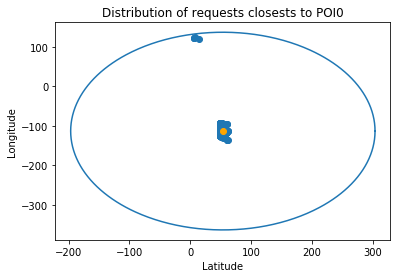

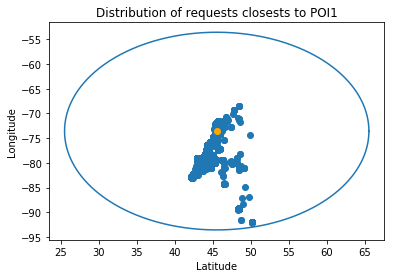

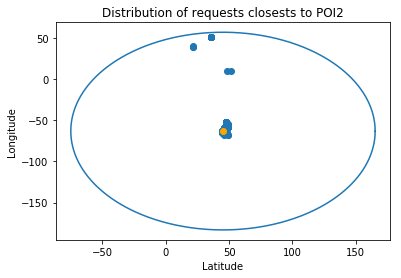

In [416]:
r = [250,20,120]
sub_dfs = [poi2_requests,poi3_requests,poi4_requests]
for i in range(3):
    t = np.arange(0, 2*np.pi, 0.01)
    x = (r[i] * np.cos(t))+pois_coord_list[i][0]
    y = (r[i] * np.sin(t))+pois_coord_list[i][1]
    plt.plot(x,y)
    plt.scatter(sub_dfs[i]['Latitude'].values, sub_dfs[i]['Longitude'].values)
    plt.scatter(pois_coord_list[i][0],pois_coord_list[i][1], color = 'orange')
    plt.title('Distribution of requests closests to POI{}'.format(i))
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()
    


# 4a. Model

## 4a.1. 
### To visualize the popularity of each POI, map them to a scale that ranges from -10 to 10. Please provide a mathematical model to implement this, taking into consideration of extreme cases and outliers. Aim to be more sensitive around the average and give as much visual differentiability as possible.

In [ ]:
# Filter out outliers(any requests further than 3 standard deviation from the mean)

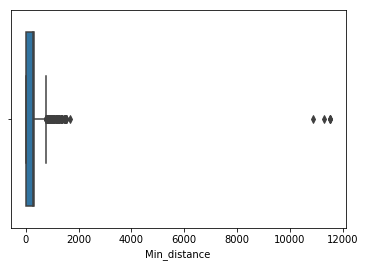

In [417]:
# visualizing the outliers using boxplots 
import seaborn as sns
sns.boxplot(x=poi2_requests['Min_distance'])

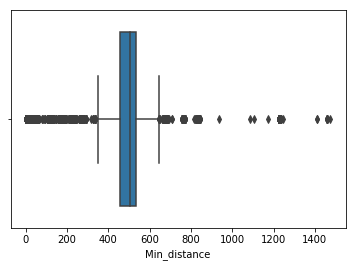

In [418]:
sns.boxplot(x=poi3_requests['Min_distance'])

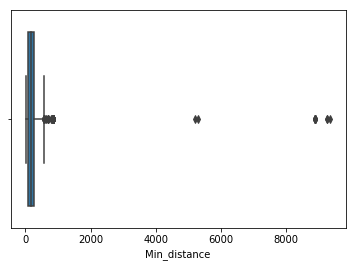

In [419]:
sns.boxplot(x=poi4_requests['Min_distance'])

In [420]:
def z_score_calculator (row,mean,std):
    z_score = (row['Min_distance'] - mean)/std
    return(z_score)

In [426]:
poi2_requests['z_score'] = poi2_requests.apply (lambda row: z_score_calculator(row,302.717751,393.968533), axis=1)

C:\Users\smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [427]:
# filter outliers (z_score > 3 or z_score < -3)
poi2_requests_no_outliers = poi2_requests.loc[abs(poi2_requests['z_score']) < 3]
print(len(poi2_requests.index))
print(len(poi2_requests_no_outliers.index))
print('number of outliers in POI2 requests:', len(poi2_requests.index) - len(poi2_requests_no_outliers.index))


8405
8388
number of outliers in POI2 requests: 17


In [428]:
poi2_requests_no_outliers.describe()

,_ID,Latitude,Longitude,Min_distance,z_score
count,8.388000e+03,8388.000000,8388.000000,8388.000000,8388.000000
mean,5.076669e+06,51.903452,-113.374562,294.391938,-0.021133
std,3.104954e+05,1.653316,4.620955,283.707074,0.720126
min,4.525101e+06,48.407330,-130.333320,0.348449,-0.767496
25%,4.809782e+06,51.015155,-114.095000,15.300020,-0.729545
50%,5.068960e+06,51.138700,-113.889000,277.574426,-0.063821
75%,5.341803e+06,53.456700,-113.441000,314.191216,0.029123
max,5.614566e+06,62.456800,-92.834400,1478.750265,2.985093


In [429]:
# POI2, corrected_radius: 1478.750265 m = 1.48 km 
# POI2 corrected_density: counts/area
poi2_corrected_density = 8388 /(np.pi*1.48*1.48)
print('POI2 density (requests/km^2):', poi2_corrected_density )


POI2 density (requests/km^2): 1218.9478293049835


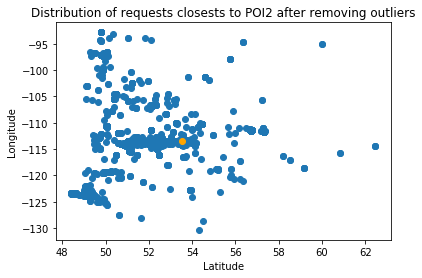

In [430]:
#POI2_corrected 

plt.scatter(poi2_requests_no_outliers['Latitude'].values, poi2_requests_no_outliers['Longitude'].values)
plt.scatter(53.546167,-113.485734, color = 'orange')
plt.title('Distribution of requests closests to POI2 after removing outliers')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [431]:
poi3_requests['z_score'] = poi3_requests.apply (lambda row: z_score_calculator(row,449.550639,224.269622), axis=1)


C:\Users\smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [432]:
# filter outliers (z_score > 3 or z_score < -3)
poi3_requests_no_outliers = poi3_requests.loc[abs(poi3_requests['z_score']) < 3]
print(len(poi3_requests.index))
print(len(poi3_requests_no_outliers.index))
print('number of outliers in POI3 requests:', len(poi3_requests.index) - len(poi3_requests_no_outliers.index))


8342
8182
number of outliers in POI3 requests: 160


In [433]:
poi3_requests_no_outliers.describe()

,_ID,Latitude,Longitude,Min_distance,z_score
count,8.182000e+03,8182.000000,8182.000000,8182.000000,8182.000000
mean,5.061312e+06,44.149970,-78.498041,433.960707,-0.069514
std,3.199950e+05,1.010038,2.493707,196.316342,0.875359
min,4.516516e+06,42.129000,-87.100100,0.809359,-2.000901
25%,4.786360e+06,43.601188,-79.719300,454.255500,0.020979
50%,5.069957e+06,43.730200,-79.415600,504.464463,0.244856
75%,5.342928e+06,44.524925,-78.863200,529.753988,0.357620
max,5.615006e+06,49.916800,-68.517900,1105.614732,2.925336


In [435]:
# POI3, corrected_radius: 1105.614732 m = 1.1 km 
# POI3 corrected_density: counts/area
poi3_corrected_density = 8182 /(np.pi*1.1*1.1)
print('POI3 density (requests/km^2):', poi3_corrected_density)

POI3 density (requests/km^2): 2152.4061890543594


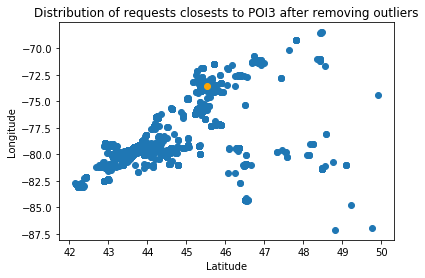

In [436]:
#POI3_corrected 

plt.scatter(poi3_requests_no_outliers['Latitude'].values, poi3_requests_no_outliers['Longitude'].values)
plt.scatter(45.521629,-73.566024, color = 'orange')
plt.title('Distribution of requests closests to POI3 after removing outliers')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [437]:
poi4_requests['z_score'] = poi4_requests.apply (lambda row: z_score_calculator(row,524.168847,1523.900297), axis=1)

C:\Users\smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [438]:
# filter outliers (z_score > 3 or z_score < -3)
poi4_requests_no_outliers = poi4_requests.loc[abs(poi4_requests['z_score']) < 3]
print(len(poi4_requests.index))
print(len(poi4_requests_no_outliers.index))
print('number of outliers in POI4 requests:', len(poi4_requests.index) - len(poi4_requests_no_outliers.index))


412
398
number of outliers in POI4 requests: 14


In [439]:
poi4_requests_no_outliers.describe()

,_ID,Latitude,Longitude,Min_distance,z_score
count,3.980000e+02,398.000000,398.000000,398.000000,398.000000
mean,5.043659e+06,45.946462,-62.818845,245.571628,-0.182819
std,3.207198e+05,1.075617,3.953643,231.110857,0.151657
min,4.530820e+06,44.335100,-68.093100,16.229069,-0.333316
25%,4.764735e+06,45.083400,-64.815000,74.692026,-0.294952
50%,5.019454e+06,46.096700,-63.917000,157.030982,-0.240920
75%,5.351936e+06,46.118300,-63.303325,269.296994,-0.167250
max,5.612336e+06,49.177100,-52.656600,855.256289,0.217263


In [239]:
# POI4, corrected_radius: 855.256289 m = 0.85 km 
# POI4 corrected_density: counts/area
poi4_corrected_density = 398 /(np.pi*0.85*0.85)
print('POI4 density (requests/km^2):', poi4_corrected_density )

POI4 density (requests/km^2): 175.34579197390823


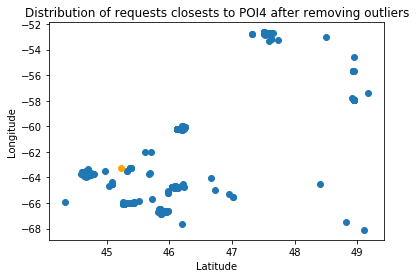

In [440]:
#POI4_corrected 

plt.scatter(poi4_requests_no_outliers['Latitude'].values, poi4_requests_no_outliers['Longitude'].values)
plt.scatter(45.224830,-63.232729, color = 'orange')
plt.title('Distribution of requests closests to POI4 after removing outliers')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

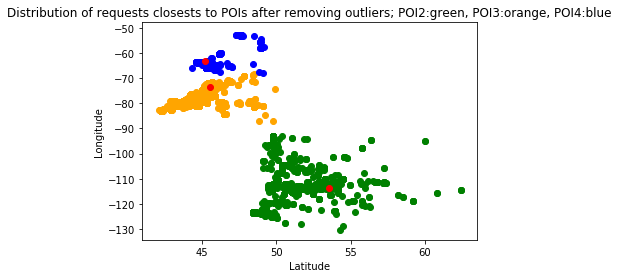

In [447]:
plt.scatter(poi2_requests_no_outliers['Latitude'].values, poi2_requests_no_outliers['Longitude'].values,
           color = 'green')
plt.scatter(53.546167,-113.485734, color = 'red')
plt.scatter(poi3_requests_no_outliers['Latitude'].values, poi3_requests_no_outliers['Longitude'].values,
           color = 'orange')
plt.scatter(45.521629,-73.566024, color = 'red')
plt.scatter(poi4_requests_no_outliers['Latitude'].values, poi4_requests_no_outliers['Longitude'].values,
           color='blue')
plt.scatter(45.224830,-63.232729, color = 'red')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Distribution of requests closests to POIs after removing outliers; POI2:green, POI3:orange, POI4:blue')
plt.show()

In [241]:
# Assuming desity ~ popularity 

poi2_popularity = 1219
poi3_popularity = 2152
poi4_popularity = 175

popularities = [poi2_popularity, poi3_popularity, poi4_popularity]



In [243]:
# Map the density values to [-10,10]

np.interp(1219,[175,2152],[-10,10])

0.5614567526555394

In [248]:
poi_list = ['POI2','POI3','POI4']
popularity_scores = [0.56,10,-10]

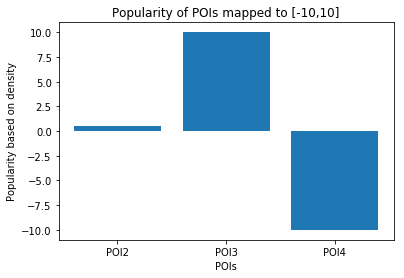

In [249]:
# plot 
plt.bar(poi_list,popularity_scores)
plt.title('Popularity of POIs mapped to [-10,10]')
plt.xlabel('POIs')
plt.ylabel('Popularity based on density')
plt.show()

# By: Alireza Rahimnejad Yazdi